# Wikipedia Thanker Study Randomization 
[J. Nathan Matias](https://twitter.com/natematias)
April 27, 2019

This code takes as input data described in the [randomization data format](https://docs.google.com/document/d/1plhoDbQryYQ32vZMXu8YmlLSp30QTdup43k6uTePOT4/edit?usp=drive_web&ouid=117701977297551627494) and produces randomizations for the Thanker study.

TODO: filter out bots

In [1]:
options("scipen"=9, "digits"=4)
library(ggplot2)
library(rlang)
library(tidyverse)
library(viridis)
library(blockTools)
library(blockrand)
library(corrplot)
library(DeclareDesign)
options(repr.plot.width=7, repr.plot.height=3.5)
sessionInfo()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.2     ✔ dplyr   0.7.8
✔ readr   1.2.1     ✔ stringr 1.3.1
✔ tibble  1.4.2     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::%||%()        masks rlang::%||%()
✖ purrr::%@%()         masks rlang::%@%()
✖ purrr::as_function() masks rlang::as_function()
✖ dplyr::filter()      masks stats::filter()
✖ purrr::flatten()     masks rlang::flatten()
✖ purrr::flatten_chr() masks rlang::flatten_chr()
✖ purrr::flatten_dbl() masks rlang::flatten_dbl()
✖ purrr::flatten_int() masks rlang::flatten_int()
✖ purrr::flatten_lgl() masks rlang::flatten_lgl()
✖ purrr::invoke()      masks rlang::invoke()
✖ dplyr::lag()         masks stats::lag()
✖ purrr::list_along()  masks rlang::list_along()
✖ purrr::modify()      masks rlang::modify()
✖ purrr::rep_along()   masks rlang::rep_along()
✖ purrr::splice()      masks rlang::spl

R version 3.5.1 (2018-07-02)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.5 LTS

Matrix products: default
BLAS: /usr/lib/libblas/libblas.so.3.6.0
LAPACK: /usr/lib/lapack/liblapack.so.3.6.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] DeclareDesign_0.12.0 estimatr_0.14        fabricatr_0.6.0     
 [4] randomizr_0.16.1     corrplot_0.84        blockrand_1.3       
 [7] blockTools_0.6-3     viridis_0.5.1        viridisLite_0.3.0   
[10] forcats_0.3.0        stringr_1.3.1        dplyr_0.7.8         
[13] purrr_0.2.5          rea

# Load Input Dataframe

In [2]:
filename = "all-merged_no_superthankers-20190427.csv"
data.path <- "~/Tresors/CivilServant/projects/wikipedia-integration/gratitude-study/Data Drills/"
thanker.df <- read.csv(file.path(data.path, "historical_survey_superthanker_merged", filename))

In [3]:
colnames(thanker.df)

[1] "user_name"                       "anonymized_id"                  
 [3] "user_id"                         "num_reverts_84_pre_treatment"   
 [5] "wikithank_84_pre_treatment"      "wikilove_84_pre_treatment"      
 [7] "is_official_bot"                 "block_actions_84_pre_treatment" 
 [9] "project_talk_84_pre_treatment"   "support_talk_84_pre_treatment"  
[11] "has_email"                       "anonymized_id.1"                
[13] "pre_newcomer_capability"         "pre_newcomer_intent"            
[15] "pre_emotionally_draining"        "pre_feel_positive"              
[17] "pre_monitoring_damaging_content" "pre_mentoring"                  
[19] "lang"

### Create Aggregate Variables

In [4]:
thanker.df$supportive_84_pre_treatment <- rowSums(thanker.df[,
                                                  c("support_talk_84_pre_treatment",
                                                    "wikithank_84_pre_treatment",
                                                    "wikilove_84_pre_treatment")], na.rm=TRUE)
thanker.df$protective_84_pre_treatment <- rowSums(thanker.df[,
                                                  c("block_actions_84_pre_treatment",
                                                    "num_reverts_84_pre_treatment")], na.rm=TRUE)


thanker.df$is_official_bot <- as.integer(thanker.df$is_official_bot) == 1

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


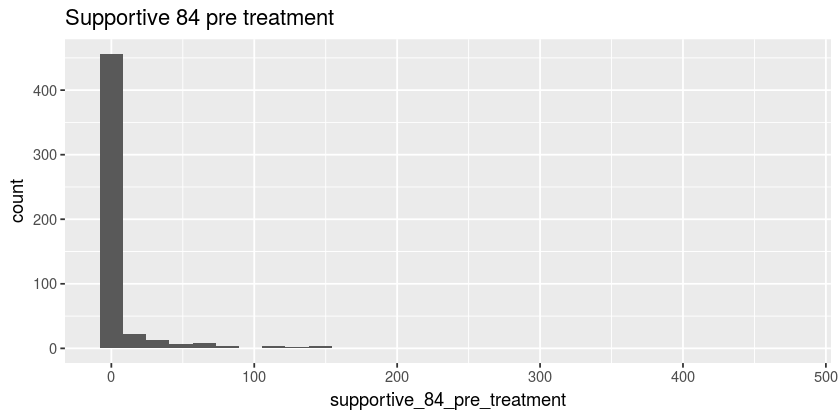

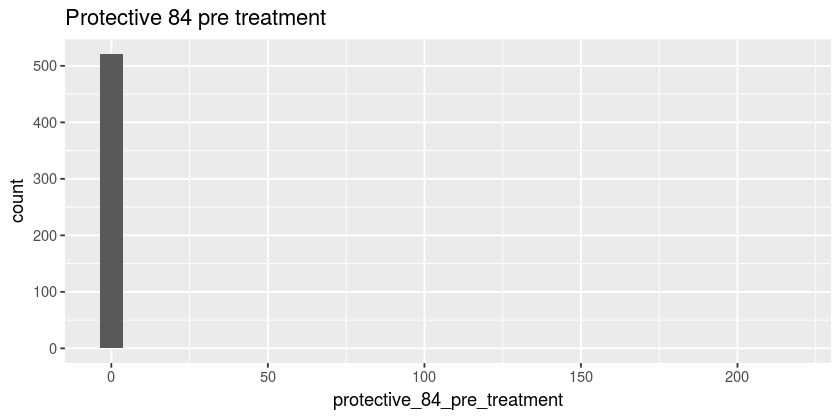

In [5]:
ggplot(thanker.df, aes(supportive_84_pre_treatment)) +
    geom_histogram() +
    ggtitle("Supportive 84 pre treatment")

ggplot(thanker.df, aes(protective_84_pre_treatment)) +
    geom_histogram() +
    ggtitle("Protective 84 pre treatment")

### Remove bots and subset values outside the 99% confidence intervals

In [6]:
print(paste("Removing", nrow(subset(thanker.df, is_official_bot==TRUE)), "officially registered bots"))
thanker.df.final <- subset(thanker.df, is_official_bot != TRUE)

## CALCULATE MEANS AND SDs before making any removals
df.support.mean <- mean(thanker.df$supportive_84_pre_treatment)
df.support.sd   <- sd(thanker.df$supportive_84_pre_treatment)
df.protect.mean <- mean(thanker.df$protective_84_pre_treatment)
df.protect.sd   <- sd(thanker.df$protective_84_pre_treatment)


print(paste("Removing", 
            nrow(subset(thanker.df, 
                        supportive_84_pre_treatment > df.support.mean + 2.58* df.support.sd)),
           "observations because supportive_84_pre_treatment is an outlier."))
thanker.df.final <- subset(thanker.df.final, supportive_84_pre_treatment <= df.support.mean + 2.58* df.support.sd)

print(paste("Removing", 
            nrow(subset(thanker.df.final, 
                        protective_84_pre_treatment > df.protect.mean + 2.58* df.protect.sd)),
           "observations because protective_84_pre_treatment is an outlier."))
thanker.df.final <- subset(thanker.df.final, protective_84_pre_treatment <= df.protect.mean + 2.58* df.protect.sd)


[1] "Removing 2 officially registered bots"
[1] "Removing 12 observations because supportive_84_pre_treatment is an outlier."
[1] "Removing 1 observations because protective_84_pre_treatment is an outlier."


### Illustrate Retained Values

In [7]:
#subset(thanker.df.final, lang=="ar")$wikilove_84_pre_treatment

In [8]:
# Illustrate Consented Thanker Participants
#
#`@param t.df the dataframe to illustrate
illustrate.thanker.data <- function(t.df){
    for(l in unique(t.df$lang)){
        corrplot(cor(t.df[,c("support_talk_84_pre_treatment",
                     "project_talk_84_pre_treatment",
                     "wikithank_84_pre_treatment",
                     "wikilove_84_pre_treatment",
                     "num_reverts_84_pre_treatment")]),
            type="upper", method = "ellipse")

        plt <- ggplot(t.df, aes(protective_84_pre_treatment, supportive_84_pre_treatment)) +
            geom_abline(intercept = 0, color="grey", linetype="dashed") +
            geom_jitter(size=1) +
            scale_colour_gradient(name="% Support Actions") +
            theme_bw() +
            ggtitle(paste(l, "Supportive and Protective Actions Before Treatment"))
        print(plt)

        plt3 <- ggplot(t.df, aes(log1p(wikithank_84_pre_treatment))) +
            geom_histogram() +         
            theme_bw() +
            ggtitle(paste(l, "Thanks Given 84 Days Previously"))

    }
}

Warning message in cor(t.df[, c("support_talk_84_pre_treatment", "project_talk_84_pre_treatment", :
“the standard deviation is zero”Warning message in cor(t.df[, c("support_talk_84_pre_treatment", "project_talk_84_pre_treatment", :
“the standard deviation is zero”

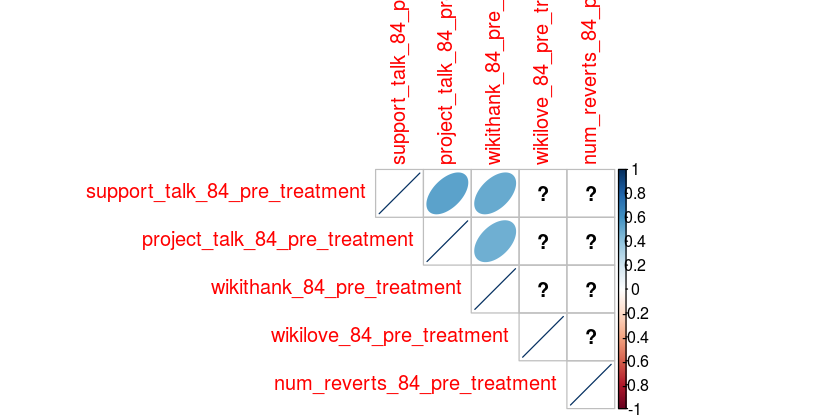

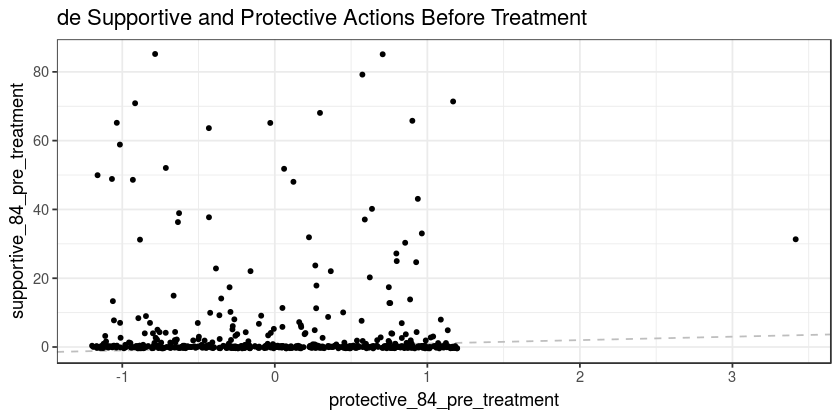

Warning message in cor(t.df[, c("support_talk_84_pre_treatment", "project_talk_84_pre_treatment", :
“the standard deviation is zero”

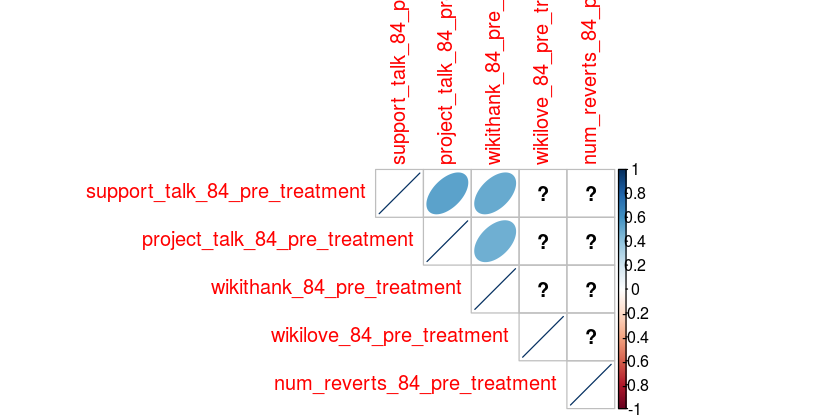

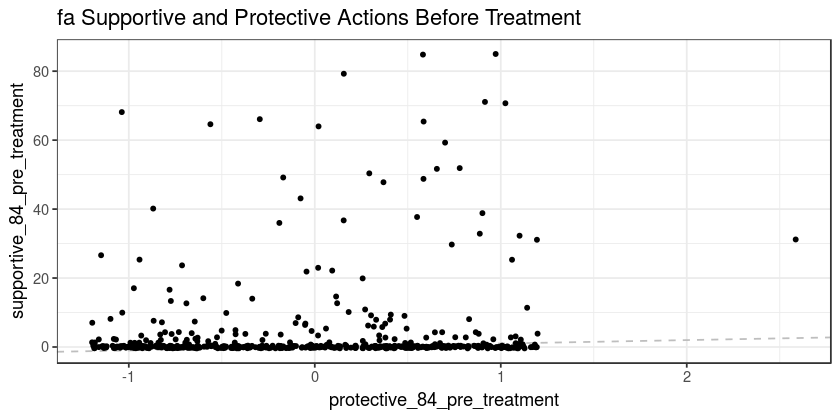

Warning message in cor(t.df[, c("support_talk_84_pre_treatment", "project_talk_84_pre_treatment", :
“the standard deviation is zero”

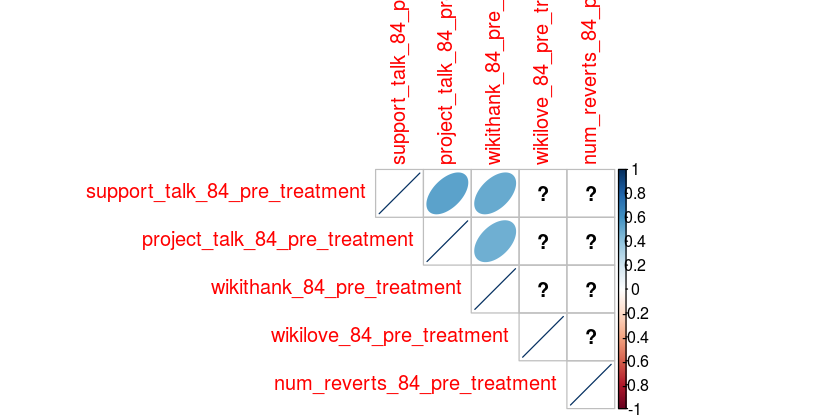

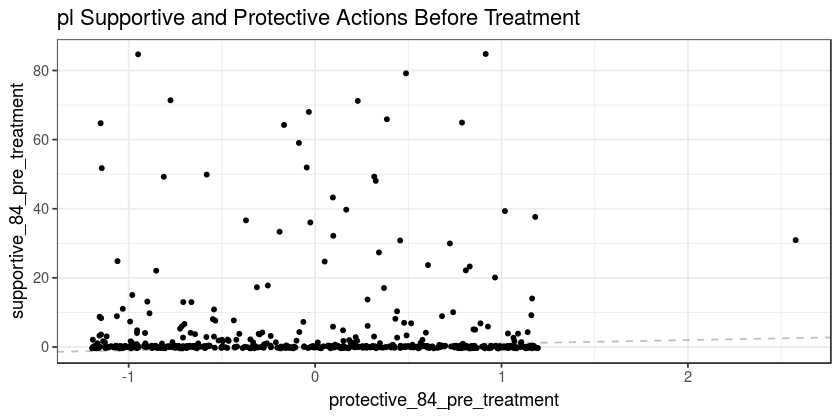

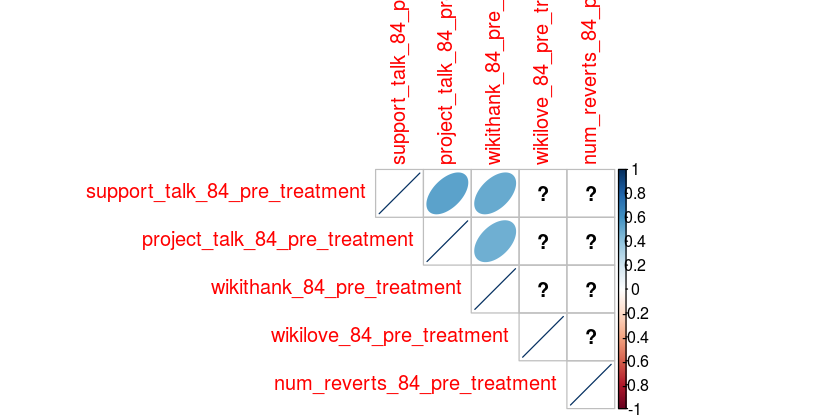

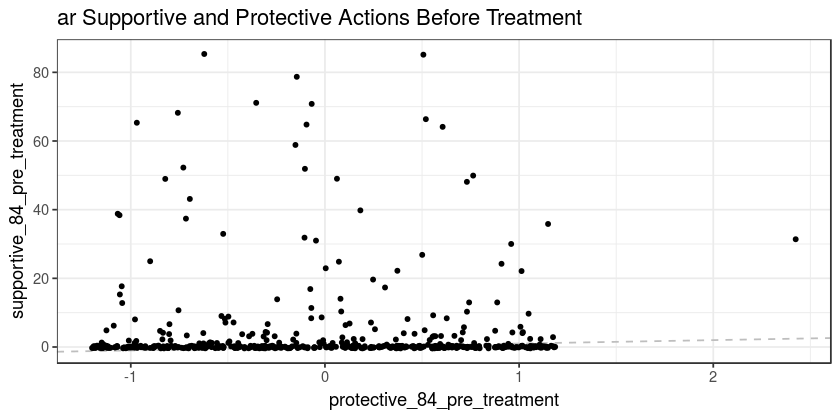

In [9]:
illustrate.thanker.data(thanker.df.final)

### Generate Protectiveness Index

In [10]:
survey.pca <- prcomp(thanker.df.final[c("pre_mentoring", "pre_monitoring_damaging_content",
                                 "pre_newcomer_intent", "pre_newcomer_capability")], center = TRUE ,scale = TRUE)
thanker.df.final$randomization_protectiveness_index <- survey.pca$x[,"PC1"]

Standard deviations (1, .., p=4):
[1] 1.0426 1.0130 0.9899 0.9523

Rotation (n x k) = (4 x 4):
                                    PC1     PC2     PC3     PC4
pre_mentoring                    0.4074 -0.2467  0.8758 -0.0782
pre_monitoring_damaging_content  0.1527  0.8476  0.2091  0.4632
pre_newcomer_intent              0.6530  0.2994 -0.2764 -0.6383
pre_newcomer_capability         -0.6199  0.3621  0.3359 -0.6098

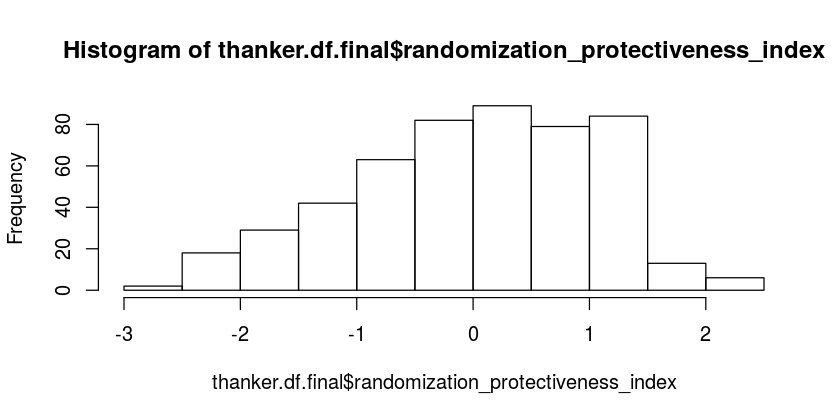

In [11]:
survey.pca
hist(thanker.df.final$randomization_protectiveness_index)

# Generate Randomization Blocks

In [12]:
## BLOCKING VARIABLES
bv = c("wikithank_84_pre_treatment", "support_talk_84_pre_treatment","randomization_protectiveness_index")

block.size = 2

## TODO: CHECK TO SEE IF I CAN DO BALANCED RANDOMIZATION
## WITHIN BLOCKS LARGER THAN 2
blockobj = block(data=thanker.df.final,
            n.tr = block.size,
            groups = "lang",
            id.vars="anonymized_id",
            block.vars = bv,
            distance ="mahalanobis"
            )
## CHECK DISTANCES
print(blockobj)
thanker.df.final$randomization_block_id <- createBlockIDs(blockobj,
                                   data=thanker.df.final,
                                   id.var = "anonymized_id")
thanker.df.final$randomization_block_size = block.size


Blocks:

Group: ar 
    Unit 1              Unit 2              Distance          
1   0PyvO05AFO          vqDwBI7N4T          0                 
2   37B4VSjh6h          wlcANdUZwy          0                 
3   4Y3tK0DJRn          EHKv7KXXtW          0                 
4   6YRcXO22j2          adfeIi0xeP          0                 
5   bujfthM5bi          65beQ1PmDz          0                 
6   dP2Soyv5rB          dQ9RBfAYGE          0                 
7   lEpYIck7Hc          VUiJq2J24R          0                 
8   LLx9tMkO9s          ZIscpMmG5l          0                 
9   oZwM8bpdNx          JPkyXBOFxQ          0                 
10  pJNQDDaaDT          piCywG9gbW          0                 
11  PWrnBpgW0g          5lZJmntcsn          0                 
12  qC0dGVPOsd          cElZPK3xMr          0                 
13  UmYqrgjZZy          KnkPfbYvWD          0                 
14  SwKUrIxMwY          2rXYcj9j9G          0.0158516783892886
15  N7tvrEMn5z          vfAkbmYgnx

# Generate Randomizations

In [13]:
## Seed generated by Brooklyn Integers
# https://www.brooklynintegers.com/int/1377541589/
set.seed(1377541589)

In [14]:
assignments <- block_ra(blocks=thanker.df.final$randomization_block_id, 
                        prob=0.5)
thanker.df.final$randomization_arm <- assignments 

In [15]:
print(thanker.df.final$randomization_arm)

  [1] 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1 1
 [38] 1 0 1 1 1 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1
 [75] 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 1 0 1 0 1 1 0 1 0 0 1
[112] 1 1 1 0 0 0 1 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 0 1 0 0 0 0
[149] 1 1 0 0 1 0 1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 0 0 1
[186] 1 1 1 0 0 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 1 0 0 1 1 0
[223] 0 0 1 1 0 1 0 0 0 0 1 0 1 0 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0
[260] 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 0 0 0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 0
[297] 1 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 0 1 0 0 1
[334] 1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0
[371] 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 1 1 0 0 0
[408] 0 1 1 1 1 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1
[445] 1 1 1 0 1 0 1 0 0 0 0 0 1 0 1 1 0 

### Check Balance

In [16]:
aggregate(thanker.df.final$randomization_arm, FUN=mean, by=list(thanker.df.final$lang))

Group.1,x
ar,0.4932
de,0.5000
fa,0.5000
pl,0.5000


# Output and Archive Randomizations

In [17]:
write.csv(thanker.df.final, file.path(data.path, "randomization_output", "all-thanker-randomization-datadrill-20190427.csv"))